Название проекта: Приоритизация гипотез и анализ A/B-теста в интернет-магазине.

Описание проекта

В крупном интернет-магазине подготовлен список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты

Описание данных

Часть 1
Файл /datasets/hypothesis.csv. Скачать датасет

Hypothesis — краткое описание гипотезы;
Reach — охват пользователей по 10-балльной шкале;
Impact — влияние на пользователей по 10-балльной шкале;
Confidence — уверенность в гипотезе по 10-балльной шкале;
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
Часть 2
Файл /datasets/orders.csv. Скачать датасет

transactionId — идентификатор заказа;
visitorId — идентификатор пользователя, совершившего заказ;
date — дата, когда был совершён заказ;
revenue — выручка заказа;
group — группа A/B-теста, в которую попал заказ.
Файл /datasets/visitors.csv. Скачать датасет

date — дата;
group — группа A/B-теста;
visitors — количество пользователей в указанную дату в указанной группе A/B-тест

Содержание

1. Открыть файлы с данными и изучить общую информацию
2. Предобработка данных
3. Приоритизация гипотез
4. Анализ A/B-теста
5. Общий вывод

## Открыть файлы с данными и изучить общую информацию

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
from scipy import stats as st
import datetime as dt

In [2]:
pd.options.display.max_colwidth = 150

Загружаем данные

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')    

In [4]:
orders = pd.read_csv('/datasets/orders.csv')

In [5]:
visitors = pd.read_csv('/datasets/visitors.csv')

Рассмотреть имеющиеся данные

In [6]:
hypothesis.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [7]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


## Предобработка данных

Проверить данные на наличие явных дубликатов

In [12]:
hypothesis.duplicated().sum()

0

In [13]:
orders.duplicated().sum()

0

In [14]:
visitors.duplicated().sum()

0

Привести к нижнему регистру название столбцов

In [15]:
hypothesis.columns = map(str.lower, hypothesis.columns)

In [16]:
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [17]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)  

In [18]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [20]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Вывод:
    В данных были приведены к нижнему регистру названия колонок в датасете hypothesis. Приведены колонки date  датасета visitors и date в датасета orders к формату datetime64. Явные дубоикаты в трёх имеющихся датасетах обнаружены не были.

## Приоритизация гипотез

### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [21]:
# Посчитаем ICE для гипотез
hypothesis['ICE'] = ( hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [22]:
# Посчитаем RICE для гипотез
hypothesis['RICE'] = (hypothesis['reach'] *  hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).round(2)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. 

In [23]:
# Посмотрим на таблицу и ответим на вопрос: почему же так произошло.
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


### Вывод
Параметр reach, то есть охват пользователей, который есть в методе RICE изменил приоретизацию гипотез. Как мы видим в пятерке лучших одни и те же гипотезы (0, 2, 6, 7, 8). Однако, если при ICE на первом месте гипотеза 8, то при расчёте RICE, на первое место вырвалась гипотеза под номером 7.
Так получилось потому, что её (7) параметр reach равен 10, в то время как у остальных гипотез он меньше.
Параметр охвата (Reach), использующийся в методе RICE изменил всю приоритетность, полученную по методу ICE.
Но задача 4 в обоих методах осталась на последнем месте.

## Анализ A/B-теста

### Построть график кумулятивной выручки по группам

In [24]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [25]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Проверить, есть ли пользователи, которые попали в обе группы и есть ли заказы, которые так же могли быть в обеих группах.

In [26]:
duplicates_users = np.intersect1d(
    orders.query('group == "A"')['visitorId'].unique(),
    orders.query('group == "B"')['visitorId'].unique()
)
duplicates_users

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

In [27]:
duplicates_users = np.intersect1d(
    orders.query('group == "A"')['transactionId'].unique(),
    orders.query('group == "B"')['transactionId'].unique()
)
duplicates_users

array([], dtype=int64)

Заказов, которые оказались бы и в группе А и в группе В не обнаружено. 

In [28]:
display(f"Процент пересекающихся пользователей {round(len(duplicates_users)/len(orders['visitorId'].unique())* 100,2)}%")

'Процент пересекающихся пользователей 0.0%'

В данных есть дублирование пользовательских id в тестируемых группах. В реальном проекте, я бы обратился к человеку, который предоставил эти данные. Так быть не должно и это свидетельствует об ошибках на этапе сбора или обработки этих данных. Возможно - человеческий фактор. Эти данные можно удалить, так как количество задвоенных id не привышает 5-10%. И потому что сложно становится доверять этим данным. Но при этом, всегда лучше смотреть на каждую ситуацию исходя и из обсалютных чисел. Проверим, сколько всего у нас было заказов в предоставленных данных и сколько из них уникальных id посетителей. 

In [29]:
display(
    f"Всего {sum(visitors['visitors'])} заказов. " 
    f"Из них {len(orders['visitorId'].unique())} уникальных пользователей."
)

'Всего 37652 заказов. Из них 1031 уникальных пользователей.'

Так как мы имеем значительное количество заказов и уникальных пользователей и количество данных, которые вызывают вопросы, не превышает 10%, можем такие удалить. Но обязательно поставить человека предоставившего данные в известность. 

In [30]:
orders = orders[~orders['visitorId'].isin(duplicates_users)]

Убедиться, что данные были удадены

In [31]:
np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

Создать массив уникальных пар значений дат и групп теста

In [32]:
datesGroups = orders[['date','group']].drop_duplicates()

Получить агрегированные кумулятивные по дням данные о заказах 

In [33]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]. \
                                     agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'transactionId' : pd.Series.nunique, 
                                          'visitorId' : pd.Series.nunique, 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']
                                                                                  )


Получить агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

In [34]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]. \
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']
                                                                                     )

Объединить кумулятивные данные в одной таблице

In [35]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

Переименовать столбцы в более понятные и проверить получившийся результат

In [36]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [37]:
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Вывести минимальные и максимальные даты из датасета orders и cumulativeData.

In [38]:
display('Минимальная дата:', orders['date'].min())
display('Максимальная дата:', orders['date'].max())

'Минимальная дата:'

Timestamp('2019-08-01 00:00:00')

'Максимальная дата:'

Timestamp('2019-08-31 00:00:00')

In [39]:
display('Минимальная дата:', cumulativeData['date'].min())
display('Максимальная дата:', cumulativeData['date'].max())

'Минимальная дата:'

Timestamp('2019-08-01 00:00:00')

'Максимальная дата:'

Timestamp('2019-08-31 00:00:00')

Максимальные и минимальные даты в новом датасете cumulativeData совпадают с аналогичными датами из изначального датасета. Анализируем данные с 1 по 31 августа 2019 года.

Создать датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и в группе B. Построить на одном графике кривую выручки группы А и группы B.

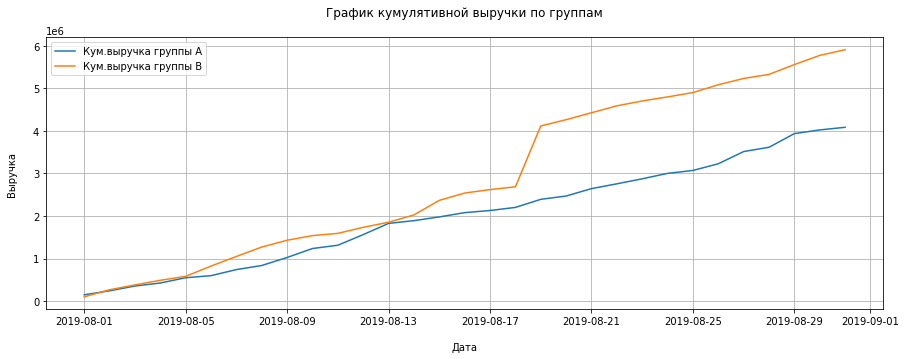

In [40]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(15,5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Кум.выручка группы A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Кум.выручка группы B')
plt.title('График кумулятивной выручки по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Выручка\n')
plt.grid()
plt.legend();

Вывод:
Выручка увеличивается во время всего теста. Но наблюдается резкий скачек в графике у группы В, возможно имеют место аномально большое количество заказов или аномально высокий средний чек

### Построить график кумулятивного среднего чека по группам

Чтобы построить графики среднего кумулятивного чека по группам — разделим кумулятивную выручку на кумулятивное число заказов.

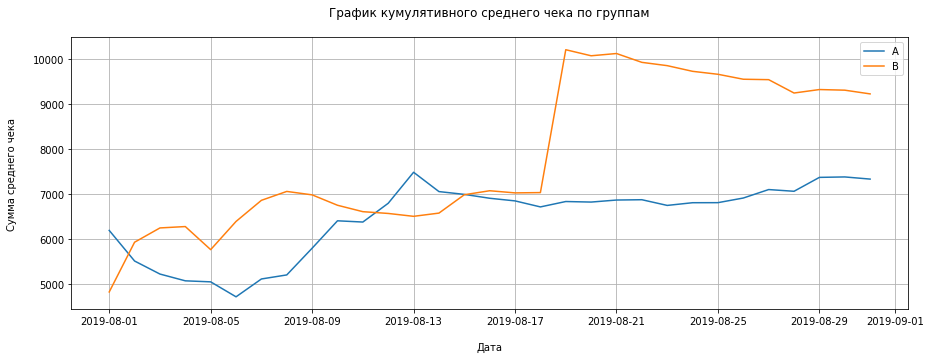

In [41]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Сумма среднего чека\n')
plt.legend() ;

Вывод:
Комулятивное значение среднего чека по группам нестабильно. Возможно имеются аномальные значения (выбросы), которые искажают общую картину. Особенно группа B.

### Построить график относительного изменения кумулятивного среднего чека группы B к группе A.

Cобрать данные в одном датафрейме

In [42]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

Построить отношение средних чеков

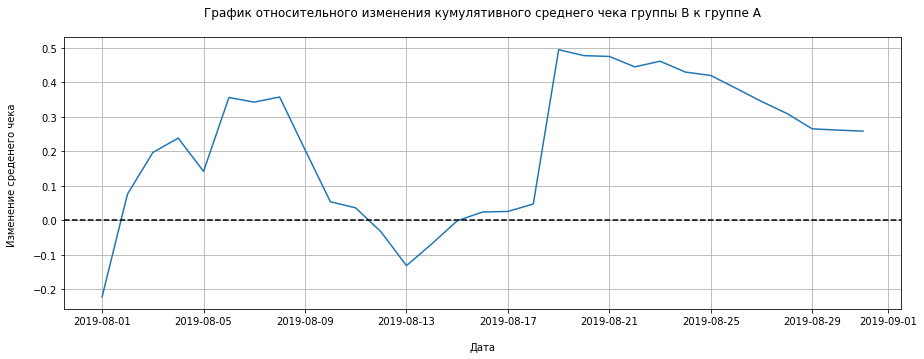

In [43]:

plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Изменение среденего чека \n')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') ;

Выводы:
    На графике относительного изменения среднего чеке между группами, видим как сильно меняются значения в определенные даты. Веротяно, тогда и были совершены аномальные заказы

### Построить график кумулятивного среднего количества заказов на посетителя по группам

Посчитать комулятивную конверсию.

In [44]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

Отделяем данные по группе A и B.

In [45]:

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']


Строим график.

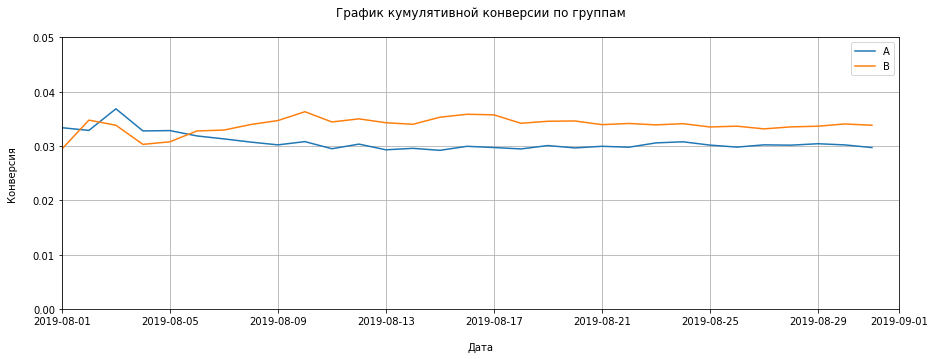

In [46]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Конверсия\n')
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]);

Выводы:
Сначала сегмент А имел большую конверсию, но чуть позже конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась.

### Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

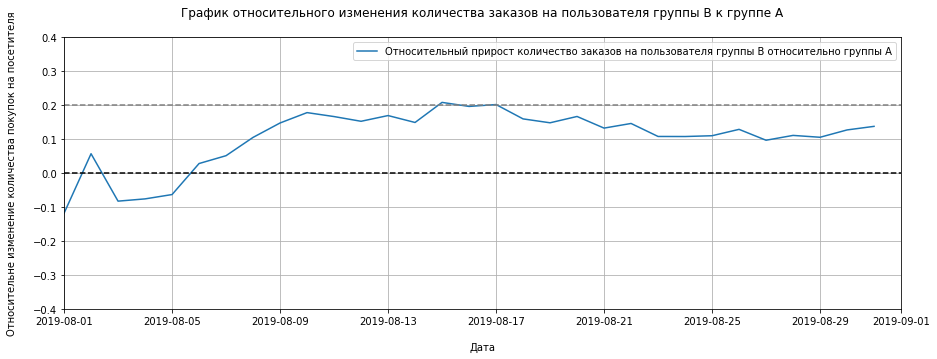

In [47]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост количество заказов на пользователя группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.4, 0.4])
plt.title('График относительного изменения количества заказов на пользователя группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Относительне изменение количества покупок на посетителя\n');

Выводы: 
В начале теста группа B незначительно проигрывала группе A, затем вырвалась вперёд и стабильно опережала.

### Построить точечный график количества заказов по пользователям.

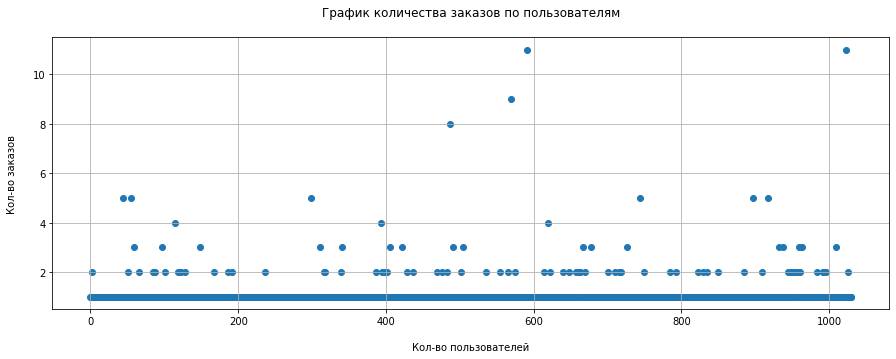

In [48]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

# серия из чисел от 0 до количества наблюдений в ordersByUsers
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График количества заказов по пользователям\n  ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Кол-во заказов\n')
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']);

Выводы: Как и предполагалось в количестве заказов есть аномальные значения. Больше всего пользователей совершили 1 заказ.
Совершивших 2 заказа значительно меньше. Но кто-то делал 8, 9 и даже 11 заказов. Граница отсечения по количеству заказов на графике должна располагаться где-то примерно между 3 и 4.
    

### Посчитать 95-й и 99-й перцентили количества заказов на пользователя.

Методом np.percentile('column', [percentile1, percentile2]) найти перцентили.

In [49]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Выводы: 95% пользователей совершают не больше 2 заказов, 99% совершают 4 заказа, аномальным будет всё, что превышает это значение. 

### Построить точечный график стоимостей заказов.

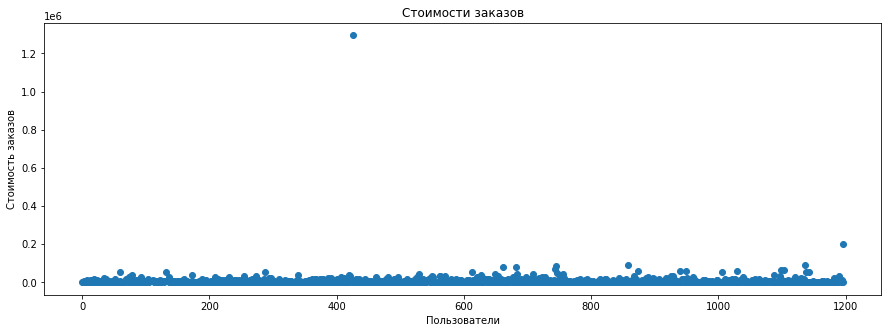

In [50]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.title("Стоимости заказов")
plt.show()

Выводы:
    Есть 2 выброса в районе 1 250 000, который выглядит весьма аномально, и 200 000. Найти точные суммы аномальных заказов.

In [51]:
orders['revenue'].sort_values().tail()

744       86620
1136      92550
858       93940
1196     202740
425     1294500
Name: revenue, dtype: int64

Аномальные заказы на сумму 1294500, второй на 202740.

Избавиться от явных выбросов и взглянуть в другом масштабе.

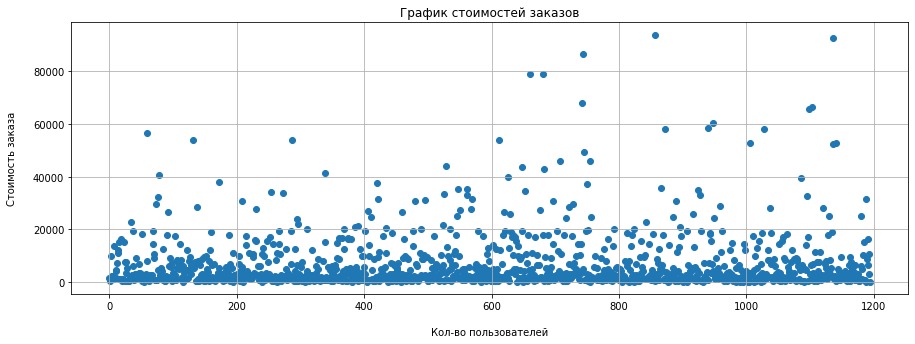

In [52]:
norm_orders = orders[orders['revenue']<=200000]['revenue']
xn_values = pd.Series(range(0,len(norm_orders)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')
plt.scatter(xn_values, norm_orders);

Большая часть всех заказов не дороже 20000. Более точное распределение посмотрим с помощью перцентилей.

### Посчитайте 95-й и 99-й перцентили стоимости заказов

In [53]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Выводы: 
    Не более чем у 95% заказов чек выше 28000 рублей, и не более чем у 1% дороже 58233 рублей.
За границу для определения аномальных заказов примем значение 58000.

### Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Начнём с подготовки данных.
Собрать в общую таблицу все данные по заказам и визитам, добавив кумулятивные показатели.

In [54]:
orders.sample()

,transactionId,visitorId,date,revenue,group
691,3589879928,1565607587,2019-08-09,3680,B


In [55]:
visitors.sample()

,date,group,visitors
26,2019-08-27,A,711


In [56]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [57]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [58]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Теперь мы можем посчитать статистическую значимость различия в количестве покупок на посетителя между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [59]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов.
Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни

In [60]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)                                                                                                                            

За нулевую гипотезу H0 примем - статистически значимых различий в конверсиях между группами нет. 
Тогда альтернативная гипотеза Н1 - статистически значимые различия есть.

Применить критерий и отформатируем p-value, округлив его до трёх знаков после запятой

In [61]:
display("alpha = 0.05")
display("p-value = {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
display("относительный прирост конверсии группы B = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

'alpha = 0.05'

'p-value = 0.017'

'относительный прирост конверсии группы B = 0.138'

Выводы:
    P-value меньше 0.05, значит стоит отвергнуть нулевую гипотезу. Анализ "сырых данных" сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А равен 13.8%.

### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

За нулевую гипотезу H0 примем - статистически значимых различий в среднем чеке между группами нет.
Тогда альтернативная гипотеза Н1 - статистически значимые различия есть.

In [62]:
display("alpha = 0.05")
display(
    "p-value = {0:.3f}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                               orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1])
)
display(
    "Относительный показатель 'B' и 'A' = {0:.3f}".format(
        orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)
) 


'alpha = 0.05'

'p-value = 0.729'

"Относительный показатель 'B' и 'A' = 0.259"

Выводы: 
    Не получилось отвергнуть нулевую гипотезу. Разница между выборками имеет случайный характер.

Относительный прирост группы В по среднему чеку заказа составил почти 26%.

### Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Приступаем к подготовке очищенных от аномалий данных.
В предыдущих расчётах мы приняли за аномальных пользователей тех, кто:

совершил 4 и больше заказов
совершил заказ дороже 58000 рублей

Сделаем срезы пользователей:

с числом заказов больше 3 — usersWithManyOrders
совершивших заказы дороже 58000 — usersWithExpensiveOrders.

Объединим их в таблицу abnormalUsers. Посмотрим количество аномальных пользователей методом shape()

In [63]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 3]['userId']], axis = 0
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head(5))
display("Всего аномальных пользователей =" ,len(abnormalUsers)) 

1099    148427295
18      199603092
23      237748145
949     887908475
744     888512513
dtype: int64

'Всего аномальных пользователей ='

20

Всего 20 аномальных пользователей. Посмотреть, как изменятся расчеты без их участия.

In [64]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 

За нулевую гипотезу H0 примем - статистически значимых различий в количестве покупок на посетителя между группами нет.
Тогда альтернативная гипотеза Н1 - статистически значимые различия есть.

Применим статистический критерий Манна-Уитни к полученным выборкам

In [65]:
display("alpha =",0.05)
display("p-value = {0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
display("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

'alpha ='

0.05

'p-value = 0.014'

"Относительный показатель 'B' и 'A' = 0.151"

Вывод:
p-value = 0.014 меньше 0.05. Поэтому, нулевую гипотезу о том, что статистически значимых различий в количестве покупок на посетителя между группами нет, - отвергаем. Это значит: и по «очищенным» данным в количестве покупок на посетителя групп A и B есть статистически значимые различия. 

Аномалии особо не повлияли на статистическую значимость. По очищенным данным p_value уменьшился с 1.7%% до 1.4%. 

А относительный выигрыш группы "B" над "A" равен почти 15.1% (чуть выше, чем с «сырыми» данными - 13.8%)

### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Выведем p-value для сравнения средних чеков между очищенными группами.

За нулевую гипотезу H0 примем: "статистически значимых различий в средних чеках между группами нет".
Тогда альтернативная гипотеза Н1 - статистически значимые различия есть.

In [66]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided')[1]))

print("Относительный показатель В и А = {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

alpha = 0.05
p-value = 0.959
Относительный показатель В и А = -0.014


##### Вывод: 
P-value = 0.959, значительно больше 0.05. Поэтому можем считать, что в среднем чеке нет различий (как и с "сырыми" данными). А вот средний чек группы B оказался незначительно (на 1.4%) ниже среднего чека группы A, в то время как по "сырым" данным, он был больше почти на ~26%. На такой результат повлияли наши аномальные заказы с большими суммами.

### Принять решение по результатам теста и объясните его

Мы выяснили, что у группы В количества покупок на посетителя выше на 15.1% по "очищенным" данным,  и по "сырым" близкое значение - 13.8%, а средние чеки групп по "очищенным данным" примерно одинаковые(незначительно ниже в группе B). Хотя по "сырым" данным можно было подумать, что разница средних чеков составляет 26% в пользу группы B.

Есть статистически значимое различие по  количеству заказов на пользователя между группами как по сырым данным, так и после фильтрации аномалий.
По сырым данным есть статистически значимое различие по среднему чеку между группами. Однако после удаления аномалий статистически значимое различия стали очень близки(даже на 1.4% ниже в группе B).
График различия  количества заказов на пользователя между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.


Основываясь на результатах проведенного А/В теста, рекомендую остановить тест и зафиксировать победу группы В по показателю  количества заказов на пользователя. Дальше отдел маркетинга может начать работу по стимуляции к увеличению среднего чека.

## Общий вывод

1. В результате предобработки данных были сделаны следующие шаги: были приведены к нижнему регистру названия колонок в датасете hypothesis. Приведены колонки date датасета visitors и date в датасета orders к формату datetime64. Явные дубоикаты в трёх имеющихся датасетах обнаружены не были.
2. В результате приоретизации гипотез были сделаны следующие выводы: параметр reach, то есть охват пользователей, который есть в методе RICE изменил приоретизацию гипотез. Как мы видим в пятерке лучших одни и те же гипотезы (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей, Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа, Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию, Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, Запустить акцию, дающую скидку на товар в день рождения). Однако, если при ICE на первом месте гипотеза 8, то при расчёте RICE, на первое место вырвалась гипотеза под номером 7(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок). Так получилось потому, что её (7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) параметр reach равен 10, в то время как у остальных гипотез он меньше. Параметр охвата (Reach), использующийся в методе RICE изменил всю приоритетность, полученную по методу ICE. Но задача 4 (Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей) в обоих методах осталась на последнем месте.
3. В процессе анализ A/B-теста в данных были выявленно дублирование пользовательских id в тестируемых группах. В реальном проекте, я бы обратился к человеку, который предоставил эти данные. Так быть не должно и это свидетельствует об ошибках на этапе сбора или обработки этих данных. Возможно - человеческий фактор. Эти данные можно удалить, так как количество задвоенных id не привышает 5-10%. При этом, заказов, которые оказались бы и в группе А и в группе В не обнаружено.
4. Мы выяснили, что у группы В конверсии выше на 13.% по "очищенным" данным,  и по "сырым" близкое значение - 13.8%, а средние чеки групп по "очищенным данным" примерно одинаковые(незначительно ниже в группе B). Хотя по "сырым" данным можно было подумать, что разница средних чеков составляет 26% в пользу группы B.

На основание графиков и проделанных вычислений, есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
По сырым данным есть статистически значимое различие по среднему чеку между группами. Однако после удаления аномалий статистически значимое различия стали очень близки(даже на 1.4% ниже в группе B).
График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.

Основываясь на результатах проведенного А/В теста, рекомендую остановить тест и зафиксировать победу группы В по показателю конверсии. Дальше отдел маркетинга может начать работу по увеличению среднего чека.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Здорово, что собрал все данные в общий вывод!
</div>

<div style="border:solid Chocolate 2px; padding: 40px">
Виталий, давай подведем итоги. Ты большой молодец, что старался и проделал такую большую работу. Мне понравилось, что ты наполнил проект развернутыми выводами и наглядно продемонстрировал каждое задание:) 
    
 Разберем над чем стоит поработать:
    
    1. В выводах дать полную формулировку гипотез, а не указывать индексы.
   
    2. Рекомендую:
    - указать решаемую бизнес-задачу;
    - вывести гипотезы полностью;
    - проверить корректность датафрейма cummulativeData;
    - проверить названия у графиков.
   
    Пересмотри работу и исправь ошибки. Обязательно пиши, если я могу тебе еще чем-то помочь. Удачи!)
  

<div class="alert alert-success">
<h2> Комментарий ревьюера v2<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Виталий, привет! Молодец, оперативно и верно доработал проект. Благодарю за обратную связь, работа принята, удачи в обучении!)
</div>